## Обнаружение объектов

План на сегодня:
1. Object detection: постановка задачи
2. Reminder: two-stage vs single-stage detectors
3. Обработка предсказаний: non-max suppression
4. Метрики

<img src="https://research.aimultiple.com/wp-content/webp-express/webp-images/uploads/2022/01/semantic-segmentation-2.png.webp" style="background:white" width="700"/>

### 1. Основные архитектуры

<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/60d31e388536752a275673aa_machine-learning-infographic.jpg" style="background:white" width="500"/>

<table style="width:100%; table-layout:flex;">
  <tr>
    <td><img height="300px" src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-24_at_5.10.31_PM.png"></td>
    <td><img height="300px" src="https://www.dlology.com/static/media/uploads/yolo/grid_cell_output.jpg"></td>
  </tr>
  <tr>
    <td>Faster RCNN</td>
    <td>YOLO</td>
  </tr>
</table>

Про SSD: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

### 2. Предсказания модели

На практике предсказания модели будут выглядеть как-то так:

<img src="https://media5.datahacker.rs/2018/11/non_max_b_boxes.png" style="background:white" width="400"/>

#### Non-max suppression



1. Сортируем гипотезы по убыванию оценки (confidence score)
2. Для каждой гипотезы в отсортированном списке:
    - добавляем в результирующий список
    - убираем из отсортированного списка все гипотезы, для которых
        *intersection over union (IoU)* выше заданного порога

Эта функция есть в `torchvision`, её используют большинство моделей детекции при постобработке предсказаний

<img src="https://habrastorage.org/r/w1560/webt/xo/8r/8y/xo8r8yprbkfhwfv9uemmpsfavve.png" style="background:white" width="800"/>

In [1]:
import torch
from torchvision.ops.boxes import nms

nms(
    torch.tensor([
        [20, 50, 120, 110],
        [30, 60, 130, 120],
        [80, 40, 180, 100],
    ]).float(),
    torch.tensor([1.0, 0.5, 0.8]),
    iou_threshold=0.8,
)

tensor([0, 2, 1])

### 3. Метрики

#### Intersection over Union (IoU)

<img src="https://habrastorage.org/r/w1560/webt/hg/xi/zj/hgxizjtbx6vlispj9rl8nzfvhsu.png" style="background:white" width="600"/>

In [2]:
import torch
from torchmetrics.detection import IntersectionOverUnion
preds = [
   {
       "boxes": torch.tensor([
            [296.55, 93.96, 314.97, 152.79],
            [298.55, 98.96, 314.97, 151.79]]),
       "labels": torch.tensor([4, 5]),
   }
]
target = [
   {
       "boxes": torch.tensor([
              [300.00, 100.00, 315.00, 150.00],
              [300.00, 100.00, 315.00, 150.00]
       ]),
       "labels": torch.tensor([4, 5]),
   }
]
metric = IntersectionOverUnion(class_metrics=True)
metric(preds, target)


{'iou': tensor(0.7756), 'iou/cl_4': tensor(0.6898), 'iou/cl_5': tensor(0.8614)}

Есть другие варианты, почитайте о них в документации:
- `DistanceIntersectionOverUnion`
- `CompleteIntersectionOverUnion`
- `GeneralizedIntersectionOverUnion`

#### Mean Average Precision (mAP)

$mAP = \frac{1}{N} \sum_i \text{AP}_i$

$AP_i$ - average precision для класса $i$ (площадь под precision-recall кривой), $N$ - число классов

$
\text{Precision} = \frac{\text{True positive}}{\text{Predicted positive}}
\quad
\text{Recall} = \frac{\text{True positive}}{\text{Total positive}}
$

<img src="https://learnopencv.com/wp-content/uploads/2022/08/mean-average-precision-map-birds-prediction-types.jpg" style="background:white" width="800"/>


Схема расчёта average precision подробнее:

1. Размечаем все предсказания на True Positive и False Positive


<img src="https://learnopencv.com/wp-content/uploads/2022/08/mean-average-precision-map-confidence-scores.png" style="background:white" width="800"/>


2. Ранжируем по убыванию confidence score, считаем precision и recall накопленным итогом
3. Оцениваем среднее значение precision по интерполированным значениям precision-recall кривой

<img src="../attachments/mapcalc-noloop.gif" style="background:white" width="800"/>



In [3]:
from torchmetrics.detection import MeanAveragePrecision
preds = [
  dict(
    boxes=torch.tensor([[258.0, 41.0, 606.0, 285.0]]),
    scores=torch.tensor([0.536]),
    labels=torch.tensor([0]),
  )
]
target = [
  dict(
    boxes=torch.tensor([[214.0, 41.0, 562.0, 285.0]]),
    labels=torch.tensor([0]),
  )
]
metric = MeanAveragePrecision(iou_type="bbox")
metric.update(preds, target)
from pprint import pprint
pprint(metric.compute())

{'classes': tensor(0, dtype=torch.int32),
 'map': tensor(0.6000),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_large': tensor(0.6000),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.6000),
 'mar_10': tensor(0.6000),
 'mar_100': tensor(0.6000),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.6000),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}


### 4. Работа с предобученными моделями из `torchvision`

Загрузим изображение для примера:

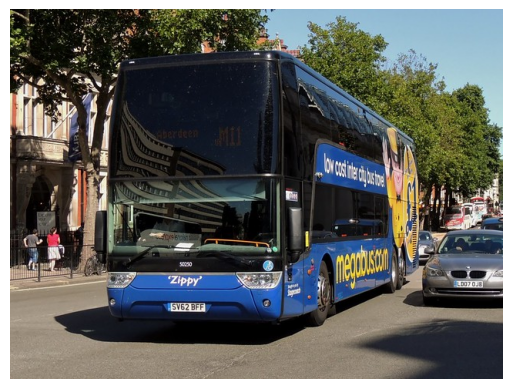

In [4]:
import requests
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_URL = "https://farm4.staticflickr.com/3805/9689301510_83d0cb76c8_z.jpg"

img = Image.open(requests.get(IMAGE_URL, stream=True).raw)

plt.imshow(img)
plt.axis(False)
plt.show()

Создадим детектор SSD с весами после обучения на датасете COCO (Common Objects in COntext), получим предсказания для нашего изображения:

In [5]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
ssd = ssdlite320_mobilenet_v3_large(weights=weights)

# переводим модель в eval - для train режима нужна правильная разметка
ssd.eval()

transform = weights.transforms()
classes = weights.meta["categories"]

with torch.no_grad():
    predictions = ssd.forward(transform(img).unsqueeze(0))[0]

print(predictions.keys())

dict_keys(['boxes', 'scores', 'labels'])


In [6]:
for key, value in predictions.items():
    print(f"{key}:", value[:3])

boxes: tensor([[118.3491,  59.5416, 526.5818, 420.8788],
        [531.5129, 278.8540, 640.0000, 383.7314],
        [ 97.6800, 297.5797, 117.1444, 323.3257]])
scores: tensor([0.9983, 0.9811, 0.2997])
labels: tensor([6, 3, 1])


Предсказаний много, давайте ограничимся только самыми уверенными:

In [7]:
mask = predictions["scores"] > 0.2
boxes = predictions['boxes'][mask]
labels = predictions['labels'][mask]
scores = predictions['scores'][mask]

In [8]:
colors_dict = {
    1: "pink",
    3: "white",
    6: "limegreen",
}

assert len(colors_dict) == len(labels.unique()), "Create as many colors as there are unique labels!"

Отрисуем рамки предсказаний:

(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

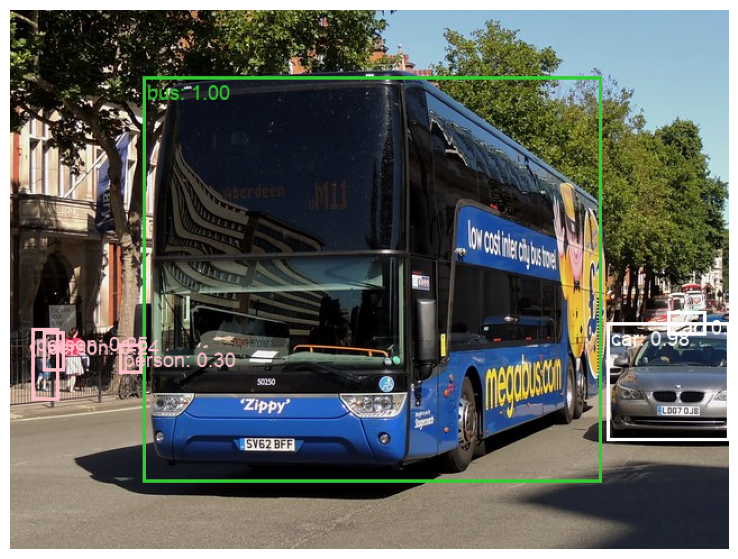

In [9]:
import torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

# нарисуем рамки
detection = draw_bounding_boxes(
    transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.uint8)])(img),
    boxes=boxes,
    labels=[f"{classes[int(label)]}: {float(score):.2f}" for label, score in zip(labels, scores)],
    width=3,
    font="Arial",
    # font="LiberationSans-Bold",
    font_size=18,
    colors=[colors_dict[ix] for ix in labels.tolist()],
)
detection: Image.Image = torchvision.transforms.ToPILImage()(detection)

fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(detection)
plt.axis(False)